# Detecting Loop from the single runs of the environment using sequence graphs.

In [7]:
import numpy as np
from tqdm import tqdm as tq
import pandas as pd
from sklearn import metrics
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.decomposition import PCA
# from pyvis.network import Network
from itertools import combinations, chain, product
import matplotlib.pyplot as plt
import networkx as nx
import faiss

import seaborn as sns

In [1]:
small_1 = {
    "freq": 3,
    "loc": "data/small_1/all_poses_freq_3.npy",
    "desc": "data/small_1/all_feat.npy",
    # "desc": "data/small/results_1/all_pca_feat.npy",
    "non_gr_seqs": [
        "data/small_1/results/groups/labels_sequence.npy",
    ],
    "seqs": [
        # "data/small/results_1/groups/r18l4_seqvlad_seq_labels_sequence.npy",
        # "data/small/results_1/groups/r18l3_gem_cat_seq_labels_sequence.npy",
    ],
    "grp_rep": [
        "seq_desc/r18l4_seqvlad_features/small_1_features.npy",
        # "seq_desc/r18l4_seqvlad_feature@5/small_features.npy",
        # "seq_desc/r19_gem_cat_feature@5/small_features.npy",
    ]
}

In [84]:
small = {
    "freq": 4,
    "loc": "data/small/all_poses_freq_4.npy",
    "desc": "data/small/all_feat.npy",
    # "desc": "data/small/results_1/all_pca_feat.npy",
    "non_gr_seqs": [
        "data/small/results_1/groups/labels_sequence.npy",
        "data/small/results_1/groups/avg_pca_seq_labels_sequence.npy",
    ],
    "seqs": [
        "data/small/results_1/groups/r18l4_seqvlad_seq_labels_sequence.npy",
        "data/small/results_1/groups/r18l3_gem_cat_seq_labels_sequence.npy",
    ],
    "grp_rep": [
        "seq_desc/r18l4_seqvlad_features/small_features.npy",
        "seq_desc/r18l4_seqvlad_feature@5/small_features.npy",
        "seq_desc/r19_gem_cat_feature@5/small_features.npy",
    ]
}

In [106]:
qsmall = {
    "freq": 3,
    "loc": "data/qsmall/all_poses_freq_3.npy",
    "desc": "data/qsmall/all_feat.npy",
    # "desc": "data/qsmall/results/all_pca_feat.npy",
    "non_gr_seqs": [
        "data/qsmall/results/groups/labels_sequence.npy",
        "data/qsmall/results/groups/avg_pca_seq_labels_sequence.npy",
    ],
    "seqs": [
        "data/qsmall/results/groups/r18l4_seqvlad_seq_labels_sequence.npy",
        "data/qsmall/results/groups/r18l3_gem_cat_seq_labels_sequence.npy",
    ],
    "grp_rep": [
        "seq_desc/r18l4_seqvlad_features/qsmall_features.npy",
        "seq_desc/r18l4_seqvlad_feature@5/qsmall_features.npy",
        "seq_desc/r19_gem_cat_feature@5/qsmall_features.npy",
    ]
}

In [4]:
rsmall = {
    "freq": 3,
    "loc": "data/rsmall/all_poses_freq_3.npy",
    "desc": "data/rsmall/all_feat.npy",
    # "desc": "data/rsmall/results/all_pca_feat.npy",
    "non_gr_seqs": [
        "data/rsmall/results/groups/labels_sequence.npy",
        "data/rsmall/results/groups/avg_pca_seq_labels_sequence.npy",
    ],
    "seqs": [
        "data/rsmall/results/groups/r18l4_seqvlad_seq_labels_sequence.npy",
        "data/rsmall/results/groups/r18l3_gem_cat_seq_labels_sequence.npy",
    ],
    "grp_rep": [
        "seq_desc/r18l4_seqvlad_features/rsmall_features.npy",
        "seq_desc/r18l4_seqvlad_feature@5/rsmall_features.npy",
        "seq_desc/r19_gem_cat_feature@5/rsmall_features.npy",
    ]
}

In [85]:
def perform_kmeans(data, k):
	model = KMeans(n_clusters=k, init="k-means++",  random_state=42) # random_state=42 does something, I'm not able to understand
	return model.fit(data)

def kmean_score_list(data, k_list=range(2,120)):
	silhouette_scores = []
	elbow_scores = []
	for k in k_list:
		model = perform_kmeans(data, k)  					 # applied kmeans clustering fitted estimator
		es = model.inertia_ 								 # calculate elbow method score
		ss = metrics.silhouette_score(data, model.labels_)   # calculate silhouette_score
		silhouette_scores += [ss]
		elbow_scores += [es]
	return k_list, silhouette_scores, elbow_scores

def top_rank_cluster_number(k_list, silhouette_scores, elbow_scores):
	elbow = KneeLocator(k_list, elbow_scores, curve='convex', direction='decreasing').knee
	silhouette = np.argmax(silhouette_scores) + 1
	return elbow, silhouette

def compute_cluster_number_frequency(data, iterations=100, k_list=range(2,120)):
	k_freq = np.zeros((2,len(k_list)+1))
	for i in tq(range(iterations)):
		_, silhouette_scores, elbow_scores = kmean_score_list(data, k_list)
		print("Elbow score = ", elbow_scores)
		print("Silhouette score = ", silhouette_scores)
		elbow_top_rank, silhouette_top_rank = top_rank_cluster_number(k_list, silhouette_scores, elbow_scores)
		k_freq[0][elbow_top_rank] += 1
		k_freq[1][silhouette_top_rank] += 1
	print(k_freq)
	return k_freq[0], k_freq[1]

In [86]:
def compute_pca(feature, rel_thresh=0.01):
	pd_feature = pd.DataFrame(feature)

	for col in pd_feature.columns:
		pd_feature[col] = (pd_feature[col] - pd_feature[col].mean() ) / pd_feature[col].std()
	
	previous_percent = 0
	current_percent = 0
	relative_tolerance = rel_thresh
	best_components = -1
	for i in range(1,min(len(feature),len(pd_feature.columns))):
		pca = PCA(n_components=i)
		pca_result = pca.fit_transform(pd_feature)
		current_percent = np.sum(pca.explained_variance_ratio_)
		if current_percent-previous_percent>relative_tolerance:
			previous_percent = current_percent
			best_components = i
		else:
			break
	print("Relevant top", best_components, " pca-components! They got Cumulative variance = ", 100*current_percent)
	print("Variation per principal component:\n",pca.explained_variance_ratio_)
	return pca_result, pca

In [87]:
class SeqGraph:
	"""
	class to build a graph for the sequence as node
	and edges weight will be similarity between the
	sequence representatives.
	"""
	def __init__(self, seq_id, seq_label,seq_color, seq_rep):
		self.seq_id = seq_id
		self.seq_rep = seq_rep
		self.seq_label = seq_label
		self.seq_color = seq_color
		self.net = None
		self.possible_metric = ["EXP_DOT", "NEG_EXP_ED", "DOT", "NEG_ED"]
	
	def _get_similitude(self,A,B,metric):
		assert metric in self.possible_metric
		if metric=="DOT":
			dt = A*B
			dt = np.sum(dt, axis=1)
			dt = (dt)/(np.linalg.norm(A, axis=1)*np.linalg.norm(B, axis=1))
			return dt
		elif metric=="NEG_ED":
			dt = (A-B)**2
			dt = np.sum(dt,axis=1)
			dt = -np.sqrt(dt)
			return dt
		elif metric=="NEG_EXP_ED":
			dt = (A-B)**2
			dt = np.sum(dt,axis=1)
			dt = -np.sqrt(dt)
			return np.exp(dt)
		elif metric=="EXP_DOT":
			dt = A*B
			dt = np.sum(dt, axis=1)
			dt = (dt)/(np.linalg.norm(A, axis=1)*np.linalg.norm(B, axis=1))
			return np.exp(dt)
		else:
			raise ValueError("Unknown Metric for computing similitudes.")
	
	def _get_edges(self, metric, ts):
		id_pairs = list(combinations(self.seq_id, 2))
		id_pairs = list(chain(*id_pairs))
		id1 = np.array(id_pairs[0::2])
		id2 = np.array(id_pairs[1::2])
		ds_pairs = list(combinations(self.seq_rep, 2))
		ds_pairs = list(chain(*ds_pairs))
		ds1 = np.array(ds_pairs[0::2])
		ds2 = np.array(ds_pairs[1::2])
		similitude = self._get_similitude(ds1,ds2, metric)
		id_similitude = np.vstack((id1,id2))
		id_similitude = np.vstack((id_similitude,similitude))
		ordey_by_similitude = lambda x: -x[-1]
		id_similitude = np.array(sorted(id_similitude.T, key=ordey_by_similitude))
		# pair_len = int(len(id_similitude)*edge_percent)
		pair_idx = id_similitude[:,-1] >= ts
		# print(id_similitude)
		# return np.array(id_similitude[:pair_len])
		return np.array(id_similitude[pair_idx])
		
	
	def build_graph(self, ts=1,metric="DOT"):
		G = nx.Graph()
		G.add_nodes_from(
			self.seq_id,
			# label=self.seq_label,
			title=self.seq_label,
			color= self.seq_color
		)
		edges = self._get_edges(metric, ts)
		edges = list(map(tuple, edges))
		G.add_weighted_edges_from(edges)
		self.net = G
		return self.net

In [88]:
class LoopDetection():
	def __init__(self, runs, tg=1, ts=1, model="seqvlad", seq_len=5):
		self.runs=runs
		self.tg=tg
		self.ts=ts
		self.all_locs = []
		self.all_desc = []
		self.all_env_loc_count = []
		self.all_seqs_rep = []
		self.all_run_seq_count = []
		self.all_label_seqs = []
		self.possible_models = ["seqvlad", "r18l3_gem_cat"]
		assert model in self.possible_models
		self.model=model
		self.seq_pca_mat = None
		self.all_pca_seqs_rep = None
		self.seq_graph = None
		self.loop_pairs = None
		self.possible_metric = ["EXP_DOT", "NEG_EXP_ED", "DOT", "NEG_ED"]
		self.seq_len=seq_len
	
	def init_raw_info(self):
		for run in self.runs:
			pos = np.load(run["loc"])
			des = np.load(run["desc"])
			self.all_locs.extend(pos)
			self.all_desc.extend(des)
			self.all_env_loc_count.append(len(pos))
		self.all_locs = np.asarray(self.all_locs)
		self.all_desc = np.asarray(self.all_desc)
	
	def init_seq_info(self):
		model_id = self.possible_models.index(self.model)
		for run in self.runs:
			label_seq = np.load(run["non_gr_seqs"][model_id],allow_pickle=True)
			group_rep = np.load(run["grp_rep"][model_id],allow_pickle=True).item()
			curr_seqr = []
			curr_label_seq = []
			for label_idx, label in enumerate(label_seq):
				for seq_idx, seq in enumerate(label):
					[s,e] = seq
					seq_id = str(label_idx)+"_"+str(seq_idx)
					if group_rep.get('test'+str(seq_id)) is not None:
						curr_seqr.append(group_rep["test"+seq_id])
						curr_label_seq.append(seq)
			self.all_run_seq_count.append(len(curr_seqr))
			self.all_label_seqs.extend(curr_label_seq)
			self.all_seqs_rep.extend(curr_seqr)
		self.all_seqs_rep = np.asarray(self.all_seqs_rep)
		self.all_label_seqs = np.asarray(self.all_label_seqs)
	
	def reduce_seq_rep(self, X=None):
		if X is None:
			X = self.all_seqs_rep
		_,self.seq_pca_mat = compute_pca(X, 0.001)
		self.all_pca_seqs_rep = self.seq_pca_mat.transform(self.all_seqs_rep)
	
	def _initialise_seq_graph(self, ts):
		seq_id = np.array(range(len(self.all_label_seqs)))
		seq_color = np.array([ i+1 for i in range(len(self.all_run_seq_count)) for _ in range(self.all_run_seq_count[i])  ])
		seq_label = np.array([ 
			str(seq_color[i])+"["+str(self.all_label_seqs[i][0])+":"+str(str(self.all_label_seqs[i][1]))+"]" for i in range(len(self.all_label_seqs))])
		self.seq_graph = SeqGraph(seq_id, seq_color, seq_label, self.all_pca_seqs_rep)
		self.seq_net = self.seq_graph.build_graph(ts)
	
	def visualise_seq_network(self):
		fig = plt.figure(1, figsize=(10, 8))
		# nx.draw(self.seq_net, with_labels=True)
		edges = self.seq_net.edges.data()
		for edge in edges:
			(seq_id1, seq_id2, _) = edge
			pose1_id = self.all_label_seqs[int(seq_id1)][0]
			pose2_id = self.all_label_seqs[int(seq_id2)][0]
			pose1 = self.all_locs[pose1_id]
			pose2 = self.all_locs[pose2_id]
			plt.plot([pose1[0],pose2[0]], [pose1[1], pose2[1]], 'ro',linestyle="--", alpha=0.2)
			plt.scatter([pose1[0],pose2[0]], [pose1[1], pose2[1]], s=60, c='b',marker='o',alpha=1)
			plt.text(pose1[0], pose1[1], str(int(seq_id1)))
			plt.text(pose2[0], pose2[1], str(int(seq_id2)))
		X = self.all_locs[:,0]
		Y = self.all_locs[:,1]
		plt.plot(X,Y, c='g')
		plt.show()

	def _get_gd_similitude(self,A,B,metric):
		assert metric in self.possible_metric
		if metric=="DOT":
			dt = A*B
			dt = np.sum(dt, axis=1)
			dt = (dt)/(np.linalg.norm(A,axis=1)*np.linalg.norm(B,axis=1))
			return dt
		elif metric=="NEG_ED":
			dt = (A-B)**2
			dt = np.sum(dt,axis=1)
			dt = -np.sqrt(dt)
			return dt
		elif metric=="NEG_EXP_ED":
			dt = (A-B)**2
			dt = np.sum(dt,axis=1)
			dt = -np.sqrt(dt)
			return np.exp(dt)
		elif metric=="EXP_DOT":
			dt = A*B
			dt = np.sum(dt, axis=1)
			dt = (dt)/(np.linalg.norm(A,axis=1)*np.linalg.norm(B,axis=1))
			return np.exp(dt)
		else:
			raise ValueError("Unknown Metric for computing similitudes.")
				
	def _seq_seq_matching(self, seq_id1, seq_id2, metric, tg):
		label_seq1 = self.all_label_seqs[int(seq_id1)]
		label_seq2 = self.all_label_seqs[int(seq_id2)]
		# if label_seq1[1]-label_seq1[0] + 1 < self.seq_len:
		# 	print("seq1 is small")
		# 	return []
		# if label_seq2[1]-label_seq2[0] + 1 < self.seq_len:
		# 	print("seq2 is small")
		# 	return []
		img_pairs = product(list(range(label_seq1[0], label_seq1[1]+1)), list(range(label_seq2[0], label_seq2[1]+1)))
		img_pairs = list(chain(*img_pairs))
		imsg1 = np.array(img_pairs[0::2])
		imsg2 = np.array(img_pairs[1::2])
		ds1 = self.all_desc[imsg1]
		ds2 = self.all_desc[imsg2]
		similitude = self._get_gd_similitude(ds1,ds2, metric)
		id_similitude = np.vstack((imsg1, imsg2))
		id_similitude = np.vstack((id_similitude,similitude))
		id_similitude = id_similitude.T
		pair_idx = id_similitude[:,-1]>=tg
		return id_similitude[pair_idx]

	# def _remove_temporarily_close_lp(self, lp_similitude, th=5):
	# 	new_lp = []
	# 	for lp in lp_similitude:
	# 		if abs(lp[0]-lp[1])<=th:
	# 			continue
	# 		else:
	# 			new_lp.append(lp)
	# 	return new_lp
	
	def compute_loop_pairs(self, seq_matching_metric="DOT", ts=None, tg=None):
		if ts is None:
			ts = self.ts
		if tg is None:
			tg=self.tg
		self.loop_pairs = []
		self._initialise_seq_graph(ts)
		edges = self.seq_net.edges.data()
		for edge in edges:
			(seq_id1, seq_id2, _) = edge
			lp_similitude = self._seq_seq_matching(seq_id1, seq_id2, seq_matching_metric, tg)
			self.loop_pairs.extend(lp_similitude)
			# self.loop_pairs.extend(self._remove_temporarily_close_lp(lp_similitude))
		return self.loop_pairs


In [8]:

small_1_ld = LoopDetection([small_1])
small_1_ld.init_raw_info()
small_1_ld.init_seq_info()
small_1_ld.reduce_seq_rep()

Relevant top 52  pca-components! They got Cumulative variance =  99.56769943237305
Variation per principal component:
 [0.22324838 0.1835732  0.12667069 0.06966002 0.06116341 0.04516444
 0.03298738 0.0256974  0.02174272 0.01591714 0.0148529  0.01361219
 0.01219919 0.01041684 0.0099675  0.00893704 0.00771956 0.0070011
 0.00686629 0.0065562  0.0059571  0.0058365  0.00514208 0.00501727
 0.00468196 0.00443742 0.00427219 0.00406826 0.00375611 0.00353953
 0.00340277 0.00321447 0.00302726 0.00279445 0.00276753 0.00252349
 0.00242212 0.00236617 0.00222737 0.0020223  0.00194875 0.00182677
 0.00168369 0.00159057 0.00155867 0.00141702 0.00140108 0.00131355
 0.00122213 0.00118277 0.00111069 0.00104061 0.00095083]


In [107]:
# small_ld = LoopDetection([small])
# small_ld.init_raw_info()
# small_ld.init_seq_info()
# small_ld.reduce_seq_rep()
qsmall_ld = LoopDetection([qsmall])
qsmall_ld.init_raw_info()
qsmall_ld.init_seq_info()
qsmall_ld.reduce_seq_rep()
# rsmall_ld = LoopDetection([rsmall])
# rsmall_ld.init_raw_info()
# rsmall_ld.init_seq_info()
# rsmall_ld.reduce_seq_rep()

Relevant top 39  pca-components! They got Cumulative variance =  99.99999403953552
Variation per principal component:
 [0.26416856 0.18458927 0.08971929 0.06442781 0.05973225 0.04706445
 0.0279078  0.02609109 0.02407326 0.02036312 0.01841812 0.01601726
 0.01510283 0.01205971 0.01165419 0.01070052 0.00927029 0.00915121
 0.00845291 0.00756436 0.00674047 0.00644273 0.00614196 0.00538273
 0.00516132 0.00479698 0.00448946 0.0039419  0.0036348  0.00355448
 0.00330786 0.00316319 0.00307919 0.00274803 0.00268523 0.00250261
 0.0021632  0.0019558  0.00157974]


In [ ]:
small_LP = small_ld.compute_loop_pairs(ts=0.002,tg=0.5)
small_ld.visualise_seq_network()
qsmall_LP = qsmall_ld.compute_loop_pairs(ts=0.002,tg=0.5)
qsmall_ld.visualise_seq_network()
rsmall_LP = rsmall_ld.compute_loop_pairs(ts=0.002,tg=0.5)
rsmall_ld.visualise_seq_network()

In [ ]:
small_LP = small_ld.compute_loop_pairs(ts=0.8,tg=0.7)
print(len(small_LP))
small_ld.visualise_seq_network()
small_LP = small_ld.compute_loop_pairs(ts=0.9,tg=0.7)
print(len(small_LP))
small_ld.visualise_seq_network()
small_LP = small_ld.compute_loop_pairs(ts=0.95,tg=0.7)
print(len(small_LP))
small_ld.visualise_seq_network()

# Evaluate the LPs

In [90]:
def get_precision(lp, loc, r=5):
	tp = 0
	dt = {}
	for (a,b,s) in lp:
		x = int(a)
		y = int(b)
		lx = loc[x]
		ly = loc[y]
		if str(a)+"-"+str(b) in dt:
			continue
		elif str(b)+"-"+str(a) in dt:
			continue
		else:
			dt[str(a)+"-"+str(b)]=1
		if np.sqrt(np.sum((lx-ly)**2))<=r:
			tp+=1
	if len(lp)==0:
		return 0
	return tp/len(lp)

def get_recall(lp,loc,r=5):
	all_p = 0
	loc_p = list(combinations(loc, 2))
	for p in loc_p:
		lx = p[0]
		ly = p[1]
		if np.sqrt(np.sum((lx-ly)**2))<=r:
			all_p+=1
	tp = 0
	dt = {}
	for (a,b,s) in lp:
		x = int(a)
		y = int(b)
		if str(a)+"-"+str(b) in dt:
			continue
		elif str(b)+"-"+str(a) in dt:
			continue
		else:
			dt[str(a)+"-"+str(b)]=1
		lx = loc[x]
		ly = loc[y]
		if np.sqrt(np.sum((lx-ly)**2))<=r:
			tp+=1
	return tp/all_p

def PR_curve(small_LP, small_ld_loc, title):
	R_P = []
	rad = np.arange(1, 20, 1)
	for r in rad:
		R_P.append([
			get_recall(small_LP, small_ld_loc, r),
			get_precision(small_LP, small_ld_loc, r)
		])
	R_P = np.array(sorted(R_P))
	fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
	fig.set_figheight(7)
	fig.set_figwidth(18)
	ax1.plot(R_P[:,0], R_P[:,1])
	# ax1.set(xlabel="Recall", ylabel="Precision")
	ax2.plot(rad, R_P[:,0])
	# ax1.set(xlabel="Radius of GT", ylabel="Recall")
	ax3.plot(rad, R_P[:,1])
	# ax1.set(xlabel="Radius of GT", ylabel="Precision")
	plt.title(title)
	plt.show()


def PR12_curve(small_LP1, small_LP2, small_ld_loc, title):
	R_P1 = []
	R_P2 = []
	rad = np.arange(1, 20, 1)
	for r in rad:
		R_P1.append([
			get_recall(small_LP1, small_ld_loc, r),
			get_precision(small_LP1, small_ld_loc, r)
		])
		R_P2.append([
			get_recall(small_LP2, small_ld_loc, r),
			get_precision(small_LP2, small_ld_loc, r)
		])
	R_P1 = np.array(sorted(R_P1))
	R_P2 = np.array(sorted(R_P2))
	fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
	fig.set_figheight(7)
	fig.set_figwidth(18)
	ax1.plot(R_P1[:,0], R_P1[:,1])
	ax1.plot(R_P2[:,0], R_P2[:,1])
	ax2.plot(rad, R_P1[:,0])
	ax2.plot(rad, R_P2[:,0])
	ax3.plot(rad, R_P1[:,1])
	ax3.plot(rad, R_P2[:,1])
	plt.title(title)
	plt.show()

In [ ]:
PR_curve(small_LP, small_ld.all_locs, "small-dataset")
PR_curve(qsmall_LP, qsmall_ld.all_locs, "qsmall-dataset")
PR_curve(rsmall_LP, rsmall_ld.all_locs, "rsmall-dataset")

# Comparing sequence based system LPs vs GD based system LPs

In [91]:
def compute_gd_lp(run, tg=1, exclude_previous_frame=5, metric="DOT", pca=False):
	loc = np.load(run["loc"])
	des = np.load(run["desc"]).astype('float32')
	if pca:
		des, _= compute_pca(des, 0.001)
	lp = []
	for i in range(len(loc)):
		ref_set_idx = set(range(i))
		ref_set_idx = list(ref_set_idx - set(range(i-exclude_previous_frame,i)))
		# ref_set_idx = list(ref_set_idx - set(range(i-exclude_previous_frame,i+exclude_previous_frame+1)))
		if len(ref_set_idx)<=0:
			continue
		ref_set = des[ref_set_idx]
		query = des[i]
		if metric=="DOT":
			dt = lambda x,y: np.sum(x*y)/(np.linalg.norm(x)*np.linalg.norm(x))
			curr_lp = [ [i,rd_idx, dt(query, rd)] for rd_idx,rd in enumerate(ref_set)  if dt(query, rd)>tg ]
		else:
			raise ValueError("No new metric defined")
		# faiss_index = faiss.IndexFlatL2(len(ref_set[0]))
		# faiss_index.add(ref_set.copy(order='C'))
		# distances, predictions = faiss_index.search(np.array([query]), len(ref_set_idx))
		# curr_lp = [ [i,ref_set_idx[predictions[0][j]], distances[0][j]] for j in range(len(distances[0])) if distances[0][j]>tg ]
		lp.extend(curr_lp)
	lp = np.array(lp)
	# uniqueLP, idx_start, idx_count = np.unique(np.sort(lp[:,:2],axis=1), axis=0, return_index=True, return_counts=True)
	return lp
	# return lp[idx_start]

In [ ]:
tmp_small_LP=compute_gd_lp(small, tg=0.5)
print(tmp_small_LP.shape)
print(get_recall(tmp_small_LP, small_ld.all_locs))

In [ ]:
print(len(small_LP))
print(len(qsmall_LP))
print(len(rsmall_LP))

In [ ]:
gd_small_LP=compute_gd_lp(small, tg=0.5)
gd_qsmall_LP=compute_gd_lp(qsmall, tg=0.5)
gd_rsmall_LP=compute_gd_lp(rsmall, tg=0.5)
print(gd_small_LP.shape)
print(gd_qsmall_LP.shape)
print(gd_rsmall_LP.shape)
# plt.hist(gd_small_LP[:,-1])

In [ ]:
PR12_curve(small_LP, gd_small_LP, small_ld.all_locs, "small-dataset")
PR12_curve(qsmall_LP, gd_qsmall_LP, qsmall_ld.all_locs, "qsmall-dataset")
PR12_curve(rsmall_LP, gd_rsmall_LP, rsmall_ld.all_locs, "rsmall-dataset")

# Fix GT-radius, check values recall of combinations of tg, ts

In [92]:


def plot_tg_ts_PR(X,Y,P,R):
	dataP = []
	dataR = []
	dP1 = []
	dP2 = []
	dR1 = []
	dR2 = []
	for i in range(len(X)):
		dataP.append([X[i],Y[i],P[i,0]-P[i,1]])
		dataR.append([X[i],Y[i],R[i,0]-R[i,1]])
		dP1.append([X[i],Y[i],P[i,0]])
		dP2.append([X[i],Y[i],P[i,1]])
		dR1.append([X[i],Y[i],R[i,0]])
		dR2.append([X[i],Y[i],R[i,1]])
	dfP = pd.DataFrame(dataP, columns=['tg', 'ts', 'precision diff'])
	dfR = pd.DataFrame(dataR, columns=['tg', 'ts', 'recall diff'])
	dfP1 = pd.DataFrame(dP1, columns=['tg', 'ts', 'precision'])
	dfP2 = pd.DataFrame(dP2, columns=['tg', 'ts', 'precision'])
	dfR1 = pd.DataFrame(dR1, columns=['tg', 'ts', 'recall'])
	dfR2 = pd.DataFrame(dR2, columns=['tg', 'ts', 'recall'])
	fig = plt.figure(figsize=(15,10))
	ax = sns.heatmap( dfP.pivot("tg", "ts", "precision diff"), annot=True, fmt=".3f" , linewidth = 0.5 , cmap = 'coolwarm' )
	plt.title("Precision comparison (seq-based precision - naive method based precision)")
	plt.show()
	fig = plt.figure(figsize=(15,10))
	ax = sns.heatmap( dfR.pivot("tg", "ts", "recall diff"), annot=True, fmt=".3f" , linewidth = 0.5 , cmap = 'coolwarm' )
	plt.title("Recall comparison (seq-based recall - naive method based recall)")
	plt.show()

	fig = plt.figure(figsize=(15,10))
	ax = sns.heatmap( dfP1.pivot("tg", "ts", "precision"), annot=True, fmt=".3f" , linewidth = 0.5 , cmap = 'coolwarm' )
	plt.title("Precision seq-based ")
	plt.show()

	fig = plt.figure(figsize=(15,10))
	ax = sns.heatmap( dfP2.pivot("tg", "ts", "precision"), annot=True, fmt=".3f" , linewidth = 0.5 , cmap = 'coolwarm' )
	plt.title("Precision naive-method-based ")
	plt.show()

	fig = plt.figure(figsize=(15,10))
	ax = sns.heatmap( dfR1.pivot("tg", "ts", "recall"), annot=True, fmt=".3f" , linewidth = 0.5 , cmap = 'coolwarm' )
	plt.title("Recall seq-based ")
	plt.show()

	fig = plt.figure(figsize=(15,10))
	ax = sns.heatmap( dfR2.pivot("tg", "ts", "recall"), annot=True, fmt=".3f" , linewidth = 0.5 , cmap = 'coolwarm' )
	plt.title("Recall naive-method-based ")
	plt.show()

In [93]:
def get_lp(tg_list, ts_list,small_ld, small, rad=5):
	gds_LP = []
	seq_LP = []
	for id in range(len(tg_list)):
		print(ts_list[id], tg_list[id])
		gds_lp = compute_gd_lp(small, tg=tg_list[id])
		print("id = ", id, len(gds_lp))
		gds_LP.append(gds_lp)
		seq_lp = small_ld.compute_loop_pairs(ts=ts_list[id],tg=tg_list[id])
		print("id = ", id, len(seq_lp))
		seq_LP.append(seq_lp)
	return gds_LP, seq_LP


In [94]:
def PR_tg_ts_combinations(tg_list, ts_list,small_ld, small, rad=5):
	P = []
	R = []
	X,Y=[],[]
	for tg in tg_list:
		gds_LP = compute_gd_lp(small, tg=tg)
		gds_pr = get_precision(gds_LP, small_ld.all_locs, rad)
		gds_rc = get_recall(gds_LP, small_ld.all_locs, rad)
		for ts in tq(ts_list):
			seq_LP = small_ld.compute_loop_pairs(ts=ts,tg=tg)
			# print("ts = ",ts, " tg = ", tg, " seq_LP = ", len(seq_LP))
			seq_pr = get_precision(seq_LP, small_ld.all_locs, rad)
			seq_rc = get_recall(seq_LP, small_ld.all_locs, rad)
			P.append([seq_pr, gds_pr])
			R.append([seq_rc, gds_rc])
			X.append(tg)
			Y.append(ts)
	P = np.array(P)
	R = np.array(R)
	return X,Y,P,R


In [14]:
def print_file(name, freq,gd_lp, seq_lp, tg_list, ts_list):
    # print(tg_list, ts_list)
    # print(len(gd_lp), len(seq_lp))
    # return
    for idx in range(len(gd_lp)):
        # print("idx= ",idx)
        f = open(name+str(idx+1),'w')
        f.write("frame_freq "+str(freq)+"\n")
        f.write("tg = "+str(tg_list[idx])+"\n")
        f.write("ts = "+str(ts_list[idx])+"\n")
        f.write("naive_loop_pairs format : i j global_descriptor_similarity"+"\n")
        for p in gd_lp[idx]:
            # print(p)
            [i,j,k]=p
            f.write(str(int(i))+" "+str(int(j))+" "+str(k)+"\n")
        f.write("seqs_based_loop_pairs format : i j global_descriptor_similarity"+"\n")
        for p in seq_lp[idx]:
            [i,j,k]=p
            f.write(str(int(i))+" "+str(int(j))+" "+str(k)+"\n")
        f.close()

In [21]:
small_1_gds_LP, small_1_seq_LP= get_lp(  [0.6, 0.7, 0.8], [0.85, 0.85, 0.85], small_1_ld, small_1)

0.85 0.6
id =  0 6008
id =  0 3309
0.85 0.7
id =  1 803
id =  1 664
0.85 0.8
id =  2 25
id =  2 37


In [22]:
print_file("small_1_LP.txt", small_1["freq"], small_1_gds_LP, small_1_seq_LP,  [0.6, 0.7, 0.8], [0.85, 0.85, 0.85])

In [ ]:
small_gds_LP, small_seq_LP= get_lp( [0.6, 0.7, 0.8][-1:], [0.85, 0.85, 0.85][-1:], small_ld, small)
qsmall_gds_LP, qsmall_seq_LP= get_lp(  [0.6, 0.7, 0.8][-1:], [0.85, 0.85, 0.85][-1:], qsmall_ld, qsmall)
rsmall_gds_LP, rsmall_seq_LP= get_lp(  [0.6, 0.7, 0.8][-1:], [0.85, 0.85, 0.85][-1:], rsmall_ld, rsmall)

In [ ]:
print_file("small_LP.txt", small["freq"], small_gds_LP, small_seq_LP,  [0.6, 0.7, 0.8][-1:], [0.85, 0.85, 0.85][-1:])
print_file("qsmall_LP.txt", qsmall["freq"], qsmall_gds_LP, qsmall_seq_LP, [0.6, 0.7, 0.8][-1:], [0.85, 0.85, 0.85][-1:])
print_file("rsmall_LP.txt", rsmall["freq"], rsmall_gds_LP, rsmall_seq_LP,  [0.6, 0.7, 0.8][-1:], [0.85, 0.85, 0.85][-1:])

In [95]:
TS = np.arange(0.1, 0.8, 0.04)
TG = np.arange(0.2, 0.8, 0.04)
print("TG list = ",TG)
print("TS list = ",TS)

TG list =  [0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52 0.56 0.6  0.64 0.68 0.72
 0.76 0.8 ]
TS list =  [0.1  0.14 0.18 0.22 0.26 0.3  0.34 0.38 0.42 0.46 0.5  0.54 0.58 0.62
 0.66 0.7  0.74 0.78]


In [ ]:
print(len(small_ld.all_locs))

In [19]:
X_1,Y_1,P_1,R_1= PR_tg_ts_combinations(TG, TS, small_1_ld, small_1)

100%|██████████| 18/18 [00:10<00:00,  1.79it/s]


In [96]:
# TG = [0.52, 0.605, 0.646, 0.736]
# TS = [0.5]
X,Y,P,R= PR_tg_ts_combinations(TG, TS, small_ld, small)
# TG = [0.5183, 0.605, 0.6444, 0.736]
# TS = [0.7]
# X7,Y7,P7,R7= PR_tg_ts_combinations(TG, TS, small_ld, small)

100%|██████████| 18/18 [00:11<00:00,  1.50it/s]


In [24]:
print(X)
print(Y)
print(P5)
print(R5)

[0.52, 0.605, 0.646, 0.736, 0.5183, 0.605, 0.6444, 0.736]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[[0.37156324 0.35523581]
 [0.44465926 0.41985887]
 [0.48651349 0.44312026]
 [0.73       0.61971831]]
[[0.20295203 0.19068051]
 [0.07894963 0.07148374]
 [0.04179181 0.03509826]
 [0.00626448 0.00377585]]


In [108]:
qX,qY,qP,qR= PR_tg_ts_combinations(TG, TS, qsmall_ld, qsmall)

# TG = [0.54, 0.618, 0.658, 0.77]
# TS = [0.5]
# qX5,qY5,qP5,qR5= PR_tg_ts_combinations(TG, TS, qsmall_ld, qsmall)
# TG = [0.5335, 0.615, 0.655, 0.77]
# TS = [0.7]
# qX7,qY7,qP7,qR7= PR_tg_ts_combinations(TG, TS, qsmall_ld, qsmall)

100%|██████████| 18/18 [00:15<00:00,  1.15it/s]


In [85]:
TG = [0.54, 0.618, 0.658, 0.77]
TS = [0.5]
rX5,rY5,rP5,rR5= PR_tg_ts_combinations(TG, TS, rsmall_ld, rsmall)
TG = [0.5335, 0.615, 0.655, 0.77]
TS = [0.7]
rX7,rY7,rP7,rR7= PR_tg_ts_combinations(TG, TS, rsmall_ld, rsmall)

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


In [20]:
s=0
t=len(P_1)
print("qsmall Diff. Precision = ", (np.sum(P_1[s:t,0])-np.sum(P_1[s:t,1]))/len(P_1))
print("qsmall Diff. Recall = ", (np.sum(R_1[s:t,0])-np.sum(R_1[s:t,1]))/len(R_1))
print("qsmall Diff. Precision = ", np.sum(P_1[:,0])/len(P_1),(np.sum(P_1[:,1]))/len(P_1))
print("qsmall Diff. Recall = ", np.sum(R_1[:,0])/len(P_1),(np.sum(R_1[:,1]))/len(R_1))

qsmall Diff. Precision =  0.0640726391010478
qsmall Diff. Recall =  0.0033854071890429735
qsmall Diff. Precision =  0.36374550124199106 0.2996728621409433
qsmall Diff. Recall =  0.4425367883441909 0.43915138115514796


In [97]:
s=0
t=len(P)
# print(len(P), len(rP), len(qP))
print("small Diff. Precision = ", (np.sum(P[s:t,0])-np.sum(P[s:t,1]))/len(P))
print("small Diff. Recall = ", (np.sum(R[s:t,0])-np.sum(R[s:t,1]))/len(R))
print("small Diff. Precision = ", np.sum(P[:,0])/len(P),(np.sum(P[:,1]))/len(P))
print("small Diff. Recall = ", np.sum(R[:,0])/len(R),(np.sum(R[:,1]))/len(R))

small Diff. Precision =  0.026797872769459455
small Diff. Recall =  0.003279436864136059
small Diff. Precision =  0.45988505896639786 0.4330871861969384
small Diff. Recall =  0.3095846801491271 0.30630524328499104


In [ ]:

print("rsmall Diff. Precision = ", (np.sum(rP[s:t,0])-np.sum(rP[s:t,1]))/len(rP))
print("rsmall Diff. Recall = ",( np.sum(rR[s:t,0])-np.sum(rR[s:t,1]))/len(rP))
print("rsmall Diff. Precision = ", np.sum(rP[:,0])/len(rP),(np.sum(rP[:,1]))/len(rP))
print("rsmall Diff. Recall = ", np.sum(rR[:,0])/len(rP),(np.sum(rR[:,1]))/len(rP))

In [ ]:

print("qsmall Diff. Precision = ", (np.sum(qP[s:t,0])-np.sum(qP[s:t,1]))/len(qP))
print("qsmall Diff. Recall = ", (np.sum(qR[s:t,0])-np.sum(qR[s:t,1]))/len(qR))
print("qsmall Diff. Precision = ", np.sum(qP[:,0])/len(qP),(np.sum(qP[:,1]))/len(qP))
print("qsmall Diff. Recall = ", np.sum(qR[:,0])/len(qP),(np.sum(qR[:,1]))/len(qR))

In [89]:
def plt_lp_pr(pr_list, rc_list, title):
	fig, ax = plt.subplots(figsize=(10,8))
	labl = ["our (ts=0.5)", "our (ts=0.7)", "BoW"]
	col = ['tab:blue', 'tab:orange', 'tab:green']
	for id in range(3):
		# print("id = ",id)
		pr = pr_list[id]
		rc = rc_list[id]
		# print(pr)
		# print(rc)
		ls = ["6000", "2000", "1000", "100"]
		las = [1, 0.8, 0.6, 0.4]
		ax.scatter(rc,pr, c=col[id], s=100,label=labl[id])
		for i in range(4):
			ax.annotate(ls[i],(rc[i]-0.01,pr[i]-0.01))
	ax.legend()
	plt.title(title)
	plt.ylabel("precision")
	plt.xlabel("recall")
	plt.show()

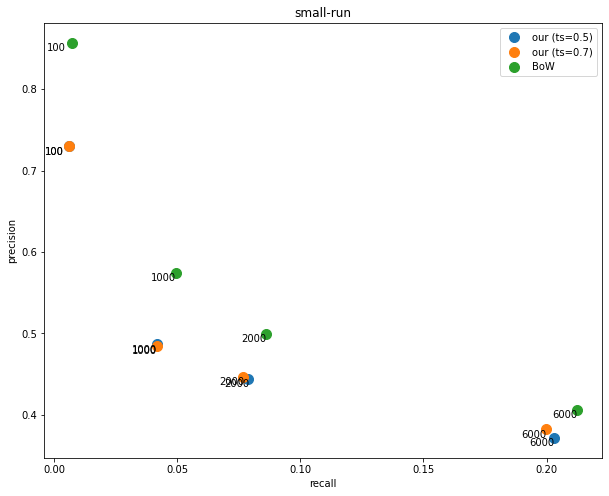

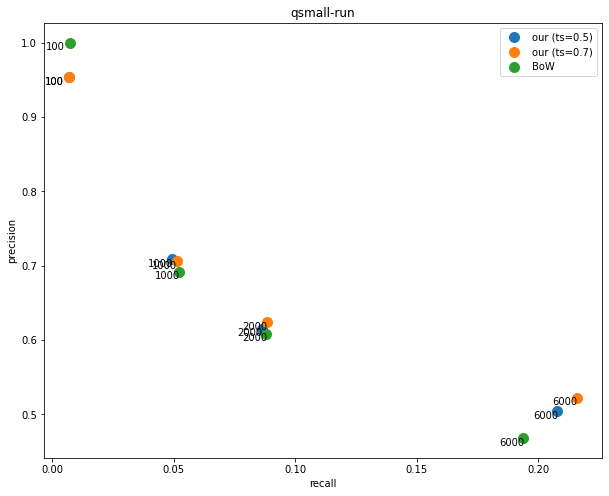

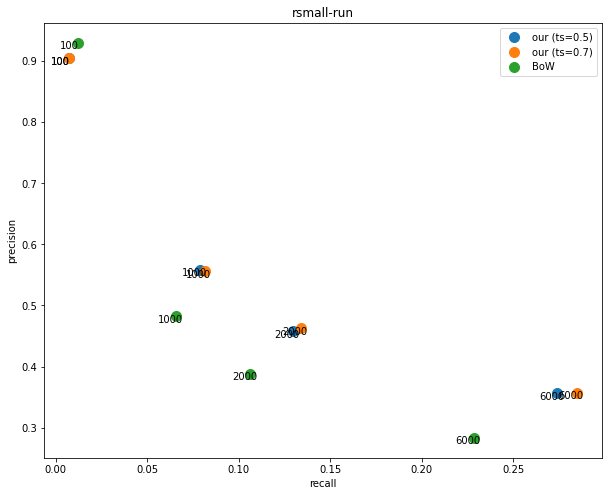

In [90]:
_ = plt_lp_pr([P5[:,0],P7[:,0],small_bow_pr],[R5[:,0],R7[:,0],small_bow_rc], "small-run")
_ = plt_lp_pr([qP5[:,0],qP7[:,0],qsmall_bow_pr],[qR5[:,0],qR7[:,0],qsmall_bow_rc], "qsmall-run")
_ = plt_lp_pr([rP5[:,0],rP7[:,0],rsmall_bow_pr],[rR5[:,0],rR7[:,0],rsmall_bow_rc], "rsmall-run")

In [98]:
def compute_BOW_PR(file_path,freq,loc):
	with open(file_path, "r") as f:
		corr = f.readlines()
	new_corr = []
	for cidx,c in enumerate(corr):
		if cidx<10:
			continue
		l = c.strip().split()
		if len(l)!=6:
			continue
		[_,l1,_,_, l2,s] = c.split()
		l1 = int(l1)
		l2 = int(l2[:-1])
		s = float(s)
		new_corr.append([(int(l1)-1)//freq, (int(l2)-1)//freq, s])

	P = []
	R = []
	NC = np.array(new_corr)
	print(NC.shape)
	new_corr = []
	for lp in NC:
		if abs(lp[0]-lp[1])<=5:
			continue
		else:
			new_corr.append(lp)
	new_corr = np.array(new_corr)
	# print(new_corr.shape)
	step = 0.1
	s = new_corr[:,2]
	s = (s - s.min(0))/s.ptp(0)
	rng = np.arange(0.1+step, 1.1-step,step)
	# # rng = [0.265, 0.2853, 0.296, 0.331] #small
	# # rng = [0.2665, 0.287, 0.299, 0.36] #qsmall
	# rng = [0.2623, 0.283, 0.294, 0.342] # rsmall
	for t in tq(rng):
		idx = s > t
		# print(len(new_corr[idx]))
		bow_pr = get_precision(new_corr[idx], loc, 5)
		bow_rc = get_recall(new_corr[idx], loc, 5)
		P.append(bow_pr)
		R.append(bow_rc)
	
	return P,R
	

In [62]:
small_1_bow_pr, small_1_bow_rc = compute_BOW_PR("LP/ENV1/small_1/bow_small_1_lp.txt",3,small_1_ld.all_locs)

(36585, 3)
(35245, 3)


  0%|          | 0/8 [00:00<?, ?it/s]

34465


 12%|█▎        | 1/8 [00:01<00:11,  1.59s/it]

34449


 25%|██▌       | 2/8 [00:07<00:25,  4.24s/it]

34176


 38%|███▊      | 3/8 [00:09<00:15,  3.04s/it]

31488


 50%|█████     | 4/8 [00:10<00:09,  2.42s/it]

18658


 62%|██████▎   | 5/8 [00:11<00:05,  1.92s/it]

3719


 75%|███████▌  | 6/8 [00:12<00:02,  1.45s/it]

239


 88%|████████▊ | 7/8 [00:12<00:01,  1.10s/it]

13


100%|██████████| 8/8 [00:13<00:00,  1.64s/it]


In [54]:

print(small_1_bow_pr)
print(small_1_bow_rc)

[0.22333922415041862, 0.22347308864064994, 0.22347308864064994, 0.22347308864064994, 0.22345704088442678, 0.22348979651078404, 0.22341446392741865, 0.22357794943820225, 0.22347737732353118, 0.22335492886178862, 0.22243004638635344, 0.2304641440668882, 0.25321756894790604, 0.30223178273729495, 0.40060851926977686, 0.5648535564853556, 0.8372093023255814, 0.9230769230769231]
[0.8416857735560651, 0.8409214979801288, 0.8409214979801288, 0.8409214979801288, 0.840812315754995, 0.8405939513047276, 0.8388470357025877, 0.8342613822469702, 0.8164646795501692, 0.7678785893656512, 0.649197510645267, 0.4694835680751174, 0.27066273610656183, 0.12272082105033301, 0.04312697892783055, 0.01473960039305601, 0.003930560104814936, 0.0013101867016049786]


In [109]:
# small_bow_pr, small_bow_rc = compute_BOW_PR("LP/ENV2/small/bow_small_lp.txt",4,small_ld.all_locs)
qsmall_bow_pr, qsmall_bow_rc = compute_BOW_PR("LP/ENV2/qsmall/bow_qsmall_lp.txt",3,qsmall_ld.all_locs)
# rsmall_bow_pr, rsmall_bow_rc = compute_BOW_PR("LP/ENV2/rsmall/bow_rsmall_lp.txt",3,rsmall_ld.all_locs)

(39340, 3)


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


In [18]:
# print(small_bow_pr)
# print(small_bow_rc)
print(qsmall_bow_pr)
print(qsmall_bow_rc)
# print(rsmall_bow_pr)
# print(rsmall_bow_rc)

[0.4466419447878039, 0.5656906906906907, 0.6517482517482518, 0.9836065573770492]
[0.22441515423366226, 0.10399558346559934, 0.06431578220964737, 0.012421503001863225]


In [63]:
def combined_our_bow(file_path,freq,small_ld):
	with open(file_path, "r") as f:
		corr = f.readlines()
	new_corr = []
	for cidx,c in enumerate(corr):
		if cidx<10:
			continue
		l = c.strip().split()
		if len(l)!=6:
			continue
		[_,l1,_,_, l2,s] = c.split()
		l1 = int(l1)
		l2 = int(l2[:-1])
		s = float(s)
		new_corr.append([(int(l1)-1)//freq, (int(l2)-1)//freq, s])


	P = []
	R = []
	
	NC = np.array(new_corr)
	new_corr = []
	for lp in NC:
		if abs(lp[0]-lp[1])<=5:
			continue
		else:
			new_corr.append(lp)
	new_corr = np.array(new_corr)

	step = 0.3
	s = new_corr[:,2]
	s = (s - s.min(0))/s.ptp(0)
	rng = np.arange(0.1+step, 1.1-step,step)
	TS = np.arange(0.2, 0.8, 0.1)
	TG = np.arange(0.2, 0.8, 0.25)
	for t in rng:
		idx = new_corr[:,2] > t
		bow_lp = np.array(new_corr[idx])
		for tg in tq(TG):
			for ts in TS:
				our_lp = np.array(small_ld.compute_loop_pairs(ts=ts,tg=tg))
				# print(type(our_lp), type(bow_lp))
				lp = np.vstack((our_lp,bow_lp))
				# print("lp = ",lp.shape)
				
				pr = get_precision(lp, small_ld.all_locs, 5)
				rc = get_recall(lp, small_ld.all_locs, 5)
				P.append(pr)
				R.append(rc)
	return P, R

In [64]:
small_1_our_bow_pr, small_1_our_bow_rc = combined_our_bow("LP/ENV1/small_1/bow_small_1_lp.txt",3,small_1_ld)

100%|██████████| 3/3 [01:21<00:00, 27.22s/it]


In [100]:
small_our_bow_pr, small_our_bow_rc = combined_our_bow("LP/ENV2/small/bow_small_lp.txt",4,small_ld)

100%|██████████| 3/3 [00:25<00:00,  8.55s/it]


In [110]:
qsmall_our_bow_pr, qsmall_our_bow_rc = combined_our_bow("LP/ENV2/qsmall/bow_qsmall_lp.txt",3,qsmall_ld)

100%|██████████| 3/3 [00:34<00:00, 11.62s/it]


In [ ]:
rsmall_our_bow_pr, rsmall_our_bow_rc = combined_our_bow("LP/ENV2/rsmall/bow_rsmall_lp.txt",3,rsmall_ld)

In [124]:
def plot_pr_curve_for_our_naive_bow(P,R, title):
    C1 = np.array([R[0],P[0]]).T
    C2 = np.array([R[1],P[1]]).T
    C3 = np.array([R[2],P[2]]).T
    C4 = np.array([R[3],P[3]]).T
    sC1 = C1[C1[:,0].argsort()]
    sC2 = C2[C2[:,0].argsort()]
    sC3 = C3[C3[:,0].argsort()]
    sC4 = C4[C4[:,0].argsort()]

    sC1 = sC1[::-1]
    sC2 = sC2[::-1]
    sC3 = sC3[::-1]
    sC4 = sC4[::-1]
    # print("C1 = ",C1)
    # print("C2 = ",C2)
    # print("sC1 = ",len(sC1))
    # print("sC2 = ",len(sC2))

    S1 = [sC1[0]]
    for i in range(1,len(sC1)):
        if sC1[i-1][0]==sC1[i][0]:
            continue
        else:
            S1.append(sC1[i])
    
    S2 = [sC2[0]]
    for i in range(1,len(sC2)):
        if sC2[i-1][0]==sC2[i][0]:
            continue
        else:
            S2.append(sC2[i])
    
    S3 = [sC3[0]]
    for i in range(1,len(sC3)):
        if sC3[i-1][0]==sC3[i][0]:
            continue
        else:
            S3.append(sC3[i])
    
    S4 = [sC4[0]]
    for i in range(1,len(sC4)):
        if sC4[i-1][0]==sC4[i][0]:
            continue
        else:
            S4.append(sC4[i])


    fig = plt.figure(figsize=(10,7))
    plt.rcParams.update({'font.size': 22})
    plt.plot(np.array(S1)[:,0], np.array(S1)[:,1], c='g', label="Our system Loop Pairs")
    plt.plot(np.array(S2)[:,0], np.array(S2)[:,1], c='r', label="ResNet+GeM Loop Pairs")
    plt.plot(np.array(S3)[:,0], np.array(S3)[:,1], c='b', label="DBoW2 Loop Pairs")
    # plt.plot(np.array(S4)[:,0], np.array(S4)[:,1], c='y', label="our system + DBoW2 Loop Pairs")
    plt.legend(["Our system Loop Pairs", "ResNet+GeM Loop Pairs","DBoW2 Loop Pairs",  ], fontsize="15")
    # plt.legend(["Our system Loop Pairs", "ResNet+GeM Loop Pairs","DBoW2 Loop Pairs", "our system + DBoW2 Loop Pairs" ], fontsize="20")
    # plt.title(title)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()


In [116]:
sFP_1 = np.array([P_1[:,0], P_1[:,1], small_1_bow_pr, small_1_our_bow_pr])
sFR_1 = np.array([R_1[:,0], R_1[:,1], small_1_bow_rc, small_1_our_bow_rc])

/tmp/ipykernel_8291/2411107386.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sFP_1 = np.array([P_1[:,0], P_1[:,1], small_1_bow_pr, small_1_our_bow_pr])
/tmp/ipykernel_8291/2411107386.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sFR_1 = np.array([R_1[:,0], R_1[:,1], small_1_bow_rc, small_1_our_bow_rc])


In [ ]:
# sFP = np.array([P[:,0], P[:,1], small_bow_pr, small_our_bow_pr])
qsFP = np.array([qP[:,0], qP[:,1], qsmall_bow_pr, qsmall_our_bow_pr])
# rsFP = np.array([rP[:,0], rP[:,1], rsmall_bow_pr, rsmall_our_bow_pr])
# sFR = np.array([R[:,0], R[:,1], small_bow_rc, small_our_bow_rc])
qsFR = np.array([qR[:,0], qR[:,1], qsmall_bow_rc, qsmall_our_bow_rc])
# rsFR = np.array([rR[:,0], rR[:,1], rsmall_bow_rc, rsmall_our_bow_rc])

/tmp/ipykernel_8291/63696817.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qsFP = np.array([qP[:,0], qP[:,1], qsmall_bow_pr, qsmall_our_bow_pr])
/tmp/ipykernel_8291/63696817.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qsFR = np.array([qR[:,0], qR[:,1], qsmall_bow_rc, qsmall_our_bow_rc])


In [ ]:
print(len(sFP))
for l in sFP:
    print(len(l))

print()
print(len(sFR))
for l in sFR:
    print(len(l))

print("======")

print(len(qsFP))
for l in qsFP:
    print(len(l))

print()
print(len(qsFR))
for l in qsFR:
    print(len(l))

print("======")

print(len(rsFP))
for l in rsFP:
    print(len(l))

print()
print(len(rsFR))
for l in rsFR:
    print(len(l))

In [ ]:
np.save("pr_small_1_our_naive_bow_ourbow",sFP_1)
np.save("rc_small_1_our_naive_bow_ourbow",sFR_1)

In [ ]:
np.save("pr_small_our_naive_bow_ourbow",sFP)
np.save("rc_small_our_naive_bow_ourbow",sFR)
np.save("pr_qsmall_our_naive_bow_ourbow",qsFP)
np.save("rc_qsmall_our_naive_bow_ourbow",qsFR)
# np.save("pr_rsmall_our_naive_bow_ourbow",rsFP)
# np.save("rc_rsmall_our_naive_bow_ourbow",rsFR)

In [ ]:
tsFP = np.load("PR_values/pr_small_our_naive_bow_ourbow.npy", allow_pickle=True)
tsFR = np.load("PR_values/rc_small_our_naive_bow_ourbow.npy", allow_pickle=True)
tqsFP = np.load("PR_values/pr_qsmall_our_naive_bow_ourbow.npy", allow_pickle=True)
tqsFR = np.load("PR_values/rc_qsmall_our_naive_bow_ourbow.npy", allow_pickle=True)
trsFP = np.load("PR_values/pr_rsmall_our_naive_bow_ourbow.npy", allow_pickle=True)
trsFR = np.load("PR_values/rc_rsmall_our_naive_bow_ourbow.npy", allow_pickle=True)
tsFP_1 = np.load("PR_values/pr_small_1_our_naive_bow_ourbow.npy", allow_pickle=True)
tsFR_1 = np.load("PR_values/rc_small_1_our_naive_bow_ourbow.npy", allow_pickle=True)

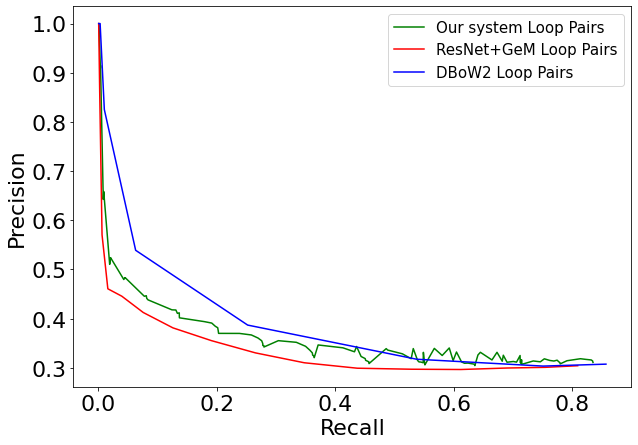

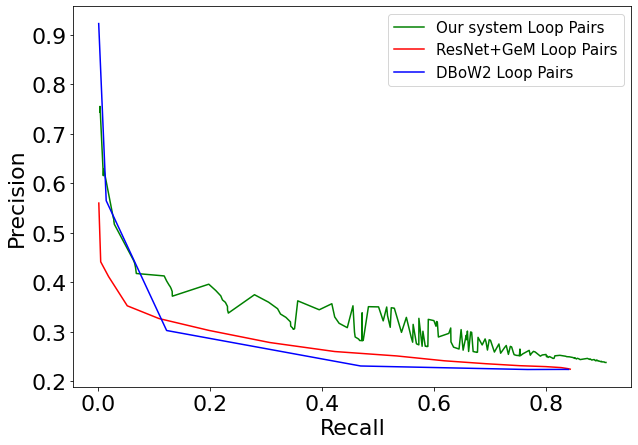

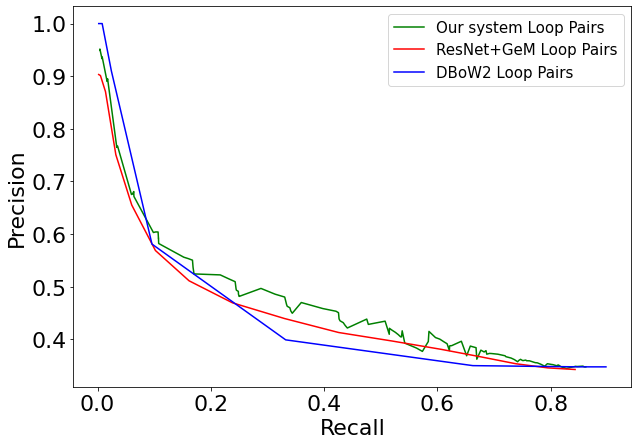

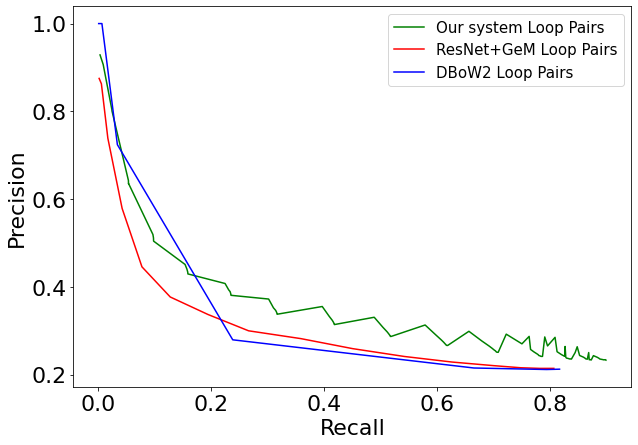

In [125]:
plot_pr_curve_for_our_naive_bow(tsFP, tsFR, "small-dataset(variable length sequences)")
plot_pr_curve_for_our_naive_bow(tsFP_1, tsFR_1, "small_1-dataset(variable length sequences)")
plot_pr_curve_for_our_naive_bow(tqsFP, tqsFR, "qsmall-dataset(variable length sequences)")
plot_pr_curve_for_our_naive_bow(trsFP, trsFR, "rsmall-dataset(variable length sequences)")

In [ ]:

# plot_pr_curve_for_our_naive_bow(sFP, sFR, "small-dataset(variable length sequences)")
plot_pr_curve_for_our_naive_bow(qsFP, qsFR, "qsmall-dataset(variable length sequences)")
# plot_pr_curve_for_our_naive_bow(rsFP, rsFR, "rsmall-dataset(variable length sequences)")


In [ ]:
print(small_bow_pr, small_bow_rc)
print(qsmall_bow_pr, qsmall_bow_rc)
print(rsmall_bow_pr, rsmall_bow_rc)

In [ ]:
def compare_with_rtabmap(rtabmap_lp_file_path, freq, small_ld, tg_list, ts_list):
    def read_rtabmap_lp(file_path, freq):
        with open(file_path, "r") as f:
            corr = f.readlines()
        new_corr = []
        for c in corr:
            c=c.strip()
            [l1, l2] = c.split()
            new_corr.append([(int(l1)-1)//freq, (int(l2)-1)//freq, -1])
        return new_corr

    # combining our system with RTABMAP LP
    def combine_RTABMAP(tg_list, ts_list,small_ld, Rtabmap_LP, rad=5):
        P = []
        R = []
        X,Y=[],[]
        for i in tq(range(len(tg_list))):
            tg = tg_list[i]
            ts = ts_list[i]
            seq_LP = small_ld.compute_loop_pairs(ts=ts,tg=tg)
            seq_pr = get_precision(seq_LP, small_ld.all_locs, rad)
            seq_rc = get_recall(seq_LP, small_ld.all_locs, rad)
            for lp in Rtabmap_LP:
                seq_LP.append(lp)
            com_pr = get_precision(seq_LP, small_ld.all_locs, rad)
            com_rc = get_recall(seq_LP, small_ld.all_locs, rad)
            P.append([com_pr, seq_pr])
            R.append([com_rc, seq_rc])
            X.append(tg)
            Y.append(ts)
        P = np.array(P)
        R = np.array(R)
        return X,Y,P,R


    Rtabmap_LP = read_rtabmap_lp(rtabmap_lp_file_path, freq)
    rtab_pr = get_precision(Rtabmap_LP, small_ld.all_locs, 5)
    rtab_rc = get_recall(Rtabmap_LP, small_ld.all_locs, 5)
    X,Y,P,R = combine_RTABMAP(tg_list, ts_list, small_ld, Rtabmap_LP)
    # print("Precision:\n")
    # for i,p in enumerate(P):
    #     print("tg= ",X[i], " ts= ",Y[i], " rtab_pr = ",rtab_pr, " com pr = ",p)
    # print("Recall:\n")
    # for i,r in enumerate(R):
    #     print("tg= ",X[i], " ts= ",Y[i], " rtab_pr = ",rtab_rc, " com pr = ",r)
    
    FP = np.array([P[:,0], P[:,1],[rtab_pr]*len(P)]).T
    FR = np.array([R[:,0], R[:,1],[rtab_rc]*len(R)]).T
    return X,Y,FP,FR

In [ ]:
rtab_X, rtab_Y, rtab_P, rtab_R = compare_with_rtabmap("LP/ENV2/small/rtabmap_small_lp.txt", 4, small_ld, TG, TS)

In [ ]:
# rtab_X, rtab_Y, rtab_P, rtab_R = compare_with_rtabmap("LP/ENV2/small/rtabmap_small_lp.txt", 4, small_ld, TG, TS)
qrtab_X, qrtab_Y, qrtab_P, qrtab_R = compare_with_rtabmap("LP/ENV2/qsmall/rtabmap_qsmall_lp.txt", 3, qsmall_ld, TG, TS)
rrtab_X, rrtab_Y, rrtab_P, rrtab_R = compare_with_rtabmap("LP/ENV2/rsmall/rtabmap_rsmall_lp.txt", 3, rsmall_ld, TG, TS)

In [ ]:
print(rtab_P[:3])
print(qrtab_P[:3])
print(rrtab_P[:3])
print(rtab_R[:3])
print(qrtab_R[:3])
print(rrtab_R[:3])

In [ ]:
def plot_pr_curve_for_rtab(P,R, title):
    C1 = np.array([R[:,0],P[:,0]]).T
    C3 = np.array([R[:,1],P[:,1]]).T
    C2 = np.array([R[:,2],P[:,2]]).T
    sC1 = C1[C1[:,0].argsort()]
    sC2 = C2[C2[:,0].argsort()]
    sC3 = C3[C3[:,0].argsort()]

    sC1 = sC1[::-1]
    sC2 = sC2[::-1]
    sC3 = sC3[::-1]
    # print("C1 = ",C1)
    # print("C2 = ",C2)
    # print("sC1 = ",len(sC1))
    # print("sC2 = ",len(sC2))

    S1 = []
    for i in range(1,len(sC1)):
        if sC1[i-1][0]==sC1[i][0]:
            continue
        else:
            S1.append(sC1[i-1])
    
    S3 = []
    for i in range(1,len(sC3)):
        if sC3[i-1][0]==sC3[i][0]:
            continue
        else:
            S3.append(sC3[i-1])

    S2 = []
    for i in range(1,len(sC2)):
        S2.append(sC2[i-1])
    
    # print(len(S1), len(S2))
    # for s in S1:
    #     print("S1 = ",s)
    # for s in S2:
    #    print("S2 = ",s)
    # print(S2)
    fig = plt.figure(figsize=(10,7))
    plt.plot(np.array(S1)[:,0], np.array(S1)[:,1], c='g', label="our system + RTABMAP Loop Pairs")
    plt.plot(np.array(S3)[:,0], np.array(S3)[:,1], c='b', label="our system  Loop Pairs")
    plt.scatter(np.array(S2)[:,0], np.array(S2)[:,1], c='r', label="RTABMAP Loop Pairs")
    plt.legend(["our system + RTABMAP Loop Pairs", "Only our system Loop Pairs","Only RTABMAP Loop Pairs" ])
    plt.title(title)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

plot_pr_curve_for_rtab(rtab_P, rtab_R, "small-dataset(variable length sequences)")
plot_pr_curve_for_rtab(qrtab_P, qrtab_R, "qsmall-dataset(variable length sequences)")
plot_pr_curve_for_rtab(rrtab_P, rrtab_R, "rsmall-dataset(variable length sequences)")


In [ ]:
def read_rtabmap_lp(file_path, freq=3):
	with open(file_path, "r") as f:
		corr = f.readlines()
	new_corr = []
	for c in corr:
		c=c.strip()
		[l1, l2] = c.split()
		new_corr.append([(int(l1)-1)//freq, (int(l2)-1)//freq, -1])
	
	print(len(new_corr), len(new_corr))
	return new_corr
Rtabmap_LP = read_rtabmap_lp("LP/ENV2/qsmall/rtabmap_qsmall_lp.txt")
# for r in Rtabmap_LP:
# 	print(r)
rtab_pr = get_precision(Rtabmap_LP, qsmall_ld.all_locs, 5)
rtab_rc = get_recall(Rtabmap_LP, qsmall_ld.all_locs, 5)
print(rtab_pr, rtab_rc)

In [ ]:
# combining our system with RTABMAP LP
def combine_RTABMAP(tg_list, ts_list,small_ld, Rtabmap_LP, rad=5):
	P = []
	R = []
	X,Y=[],[]
	for i in range(len(tg_list)):
		tg = tg_list[i]
		ts = ts_list[i]
		seq_LP = small_ld.compute_loop_pairs(ts=ts,tg=tg)
		combine_LP = seq_LP.extend(Rtabmap_LP)
		com_pr = get_precision(combine_LP, small_ld.all_locs, rad)
		com_rc = get_recall(combine_LP, small_ld.all_locs, rad)
		P.append(com_pr)
		R.append(com_rc)
		X.append(tg)
		Y.append(ts)
	P = np.array(P)
	R = np.array(R)
	return X,Y,P,R


### OBSERVATION: For highly confident edges(both either at sequence level and image level) our system is giving better precision. But the recall is almost equivalent.

In [ ]:
print("small data")
plot_tg_ts_PR(X,Y, P, R) 
print("qsmall data")
plot_tg_ts_PR(qX,qY, qP, qR)
print("qsmall data")
plot_tg_ts_PR(rX,rY, rP, rR)

# P-R curve

In [ ]:
A = np.array([1,5,3,9,2,4])
print(A)
print(A.argsort())
print(A[A.argsort()])

In [ ]:
def plot_pr_curve(P,R, title):
    C1 = np.array([R[:,0],P[:,0]]).T
    C2 = np.array([R[:,1],P[:,1]]).T
    sC1 = C1[C1[:,0].argsort()]
    sC2 = C2[C2[:,0].argsort()]

    sC1 = sC1[::-1]
    sC2 = sC2[::-1]
    # print("C1 = ",C1)
    # print("C2 = ",C2)
    # print("sC1 = ",sC1)
    # print("sC2 = ",sC2)

    S1 = []
    for i in range(1,len(sC1)):
        if sC1[i-1][0]==sC1[i][0]:
            continue
        else:
            S1.append(sC1[i-1])

    S2 = []
    for i in range(1,len(sC2)):
        if sC2[i-1][0]==sC2[i][0]:
            continue
        else:
            S2.append(sC2[i-1])

    # for s in S1:
    #     print("S1 = ",s)
    # for s in S2:
    #    print("S2 = ",s)
    fig = plt.figure(figsize=(10,7))
    plt.plot(np.array(S1)[:,0], np.array(S1)[:,1], c='g', label="our system (SD+GD)")
    plt.plot(np.array(S2)[:,0], np.array(S2)[:,1], c='r', label="naive system (only GD)")
    plt.legend(["our system (SD+GD)","naive system (only GD)" ])
    plt.title(title)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()
    

In [ ]:
plot_pr_curve(P,R, "small-dataset(variable length sequences)")

In [ ]:
plot_pr_curve(qP,qR, "qsmall-dataset(variable length sequences)")

In [ ]:
plot_pr_curve(rP,rR, "rsmall-dataset(variable length sequences)")